In [17]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, Callback
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
import shutil
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset_path = '/content/drive/MyDrive/dataset/RiceLeafDisease'
train_dir = '/content/drive/MyDrive/rice/train'  # Update this path
validation_dir = '/content/drive/MyDrive/rice/valid'
test_dir = '/content/drive/MyDrive/rice/test'  # Update this path

In [4]:
def clean_data(directory):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                try:
                    img = Image.open(file_path)
                    img.verify()  # Verify the image
                except (IOError, SyntaxError) as e:
                    print(f'Removing corrupted file: {file_path}')
                    os.remove(file_path)

# Clean the data
clean_data(dataset_path)

In [5]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [6]:
df = loading_the_data(dataset_path)
df

,filepaths,labels
0,/content/drive/MyDrive/dataset/RiceLeafDisease...,Rice Hispa
1,/content/drive/MyDrive/dataset/RiceLeafDisease...,Rice Hispa
2,/content/drive/MyDrive/dataset/RiceLeafDisease...,Rice Hispa
3,/content/drive/MyDrive/dataset/RiceLeafDisease...,Rice Hispa
4,/content/drive/MyDrive/dataset/RiceLeafDisease...,Rice Hispa
...,...,...
2495,/content/drive/MyDrive/dataset/RiceLeafDisease...,Blast
2496,/content/drive/MyDrive/dataset/RiceLeafDisease...,Blast
2497,/content/drive/MyDrive/dataset/RiceLeafDisease...,Blast
2498,/content/drive/MyDrive/dataset/RiceLeafDisease...,Blast


In [7]:
data_balance = df.labels.value_counts()
data_balance

labels
Rice Hispa           500
Bacterialblight      500
Healthy Rice Leaf    500
Brownspot            500
Blast                500
Name: count, dtype: int64

In [8]:
def split_dataset(class_dir, split_ratio):
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    random.shuffle(images)
    total_images = len(images)

    train_end = int(total_images * split_ratio[0])
    val_end = train_end + int(total_images * split_ratio[1])

    train_images = images[:train_end]
    validation_images = images[train_end:val_end]
    test_images = images[val_end:]

    return train_images, validation_images, test_images

In [9]:
# Function to copy files
def copy_files(image_list, destination_dir):
    for image in image_list:
        class_name = os.path.basename(os.path.dirname(image))
        dest_class_dir = os.path.join(destination_dir, class_name)
        os.makedirs(dest_class_dir, exist_ok=True)
        shutil.copy(image, dest_class_dir)

In [10]:
split_ratio = [0.8, 0.1, 0.1]
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        train_images, validation_images, test_images = split_dataset(class_dir, split_ratio)

        copy_files(train_images, train_dir)
        copy_files(validation_images, validation_dir)
        copy_files(test_images, test_dir)

In [11]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=10,
    class_mode='categorical',
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=10,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=10,
    class_mode='categorical',
)

Found 2000 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


In [12]:
# Count the number of images in each class
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
    return class_counts

# Count images in training, validation, and testing sets
train_class_counts = count_images(train_dir)
validation_class_counts = count_images(validation_dir)
test_class_counts = count_images(test_dir)

# Print the counts
print("Training Class Counts:", train_class_counts)
print("Validation Class Counts:", validation_class_counts)
print("Testing Class Counts:", test_class_counts)

Training Class Counts: {'Rice Hispa': 400, 'Bacterialblight': 400, 'Healthy Rice Leaf': 400, 'Brownspot': 400, 'Blast': 400}
Validation Class Counts: {'Rice Hispa': 50, 'Bacterialblight': 50, 'Healthy Rice Leaf': 50, 'Brownspot': 50, 'Blast': 50}
Testing Class Counts: {'Rice Hispa': 50, 'Bacterialblight': 50, 'Healthy Rice Leaf': 50, 'Brownspot': 50, 'Blast': 50}


In [13]:
print(train_generator.class_indices)
print(validation_generator.class_indices)

{'Bacterialblight': 0, 'Blast': 1, 'Brownspot': 2, 'Healthy Rice Leaf': 3, 'Rice Hispa': 4}
{'Bacterialblight': 0, 'Blast': 1, 'Brownspot': 2, 'Healthy Rice Leaf': 3, 'Rice Hispa': 4}


In [14]:
# Load MobileNet model with pretrained weights
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreeze some layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

17225924/17225924 [==============================] - 0s 0us/step


In [15]:
# Add custom layers on top of MobileNet
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax', kernel_regularizer=l2(0.01))
])

# Compile the model with a modified learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
class LossThresholdCallback(Callback):
    def __init__(self, threshold=0.1):
        super(LossThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') < self.threshold and logs.get('val_loss') < self.threshold:
            print(f"\nEpoch {epoch + 1}: loss {logs.get('loss'):.4f} and val_loss {logs.get('val_loss'):.4f} are below {self.threshold}. Stopping training.")
            self.model.stop_training = True

In [35]:
loss_threshold = LossThresholdCallback(threshold=0.05)

In [37]:
# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=validation_generator,
    callbacks=[loss_threshold]
)

Epoch 1/200
200/200 [==============================] - 144s 718ms/step - loss: 0.0716 - accuracy: 0.9885 - val_loss: 0.0693 - val_accuracy: 0.9920
Epoch 2/200
200/200 [==============================] - 140s 700ms/step - loss: 0.0629 - accuracy: 0.9975 - val_loss: 0.0595 - val_accuracy: 0.9960
Epoch 3/200
200/200 [==============================] - 146s 731ms/step - loss: 0.0738 - accuracy: 0.9920 - val_loss: 0.0544 - val_accuracy: 0.9960
Epoch 4/200
200/200 [==============================] - 144s 719ms/step - loss: 0.0782 - accuracy: 0.9925 - val_loss: 0.0583 - val_accuracy: 0.9960
Epoch 5/200
200/200 [==============================] - 141s 702ms/step - loss: 0.0720 - accuracy: 0.9930 - val_loss: 0.0702 - val_accuracy: 0.9880
Epoch 6/200
200/200 [==============================] - 143s 712ms/step - loss: 0.0710 - accuracy: 0.9925 - val_loss: 0.0779 - val_accuracy: 0.9920
Epoch 7/200
200/200 [==============================] - 140s 699ms/step - loss: 0.0718 - accuracy: 0.9930 - val_loss: 0

In [38]:
# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')
print(f'Validation Loss: {val_loss:.2f}')

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')
print(f'Test Loss: {test_loss:.2f}')

25/25 [==============================] - 7s 271ms/step - loss: 0.0476 - accuracy: 0.9920
Validation Accuracy: 99.20%
Validation Loss: 0.05
25/25 [==============================] - 11s 416ms/step - loss: 0.0355 - accuracy: 1.0000
Test Accuracy: 100.00%
Test Loss: 0.04


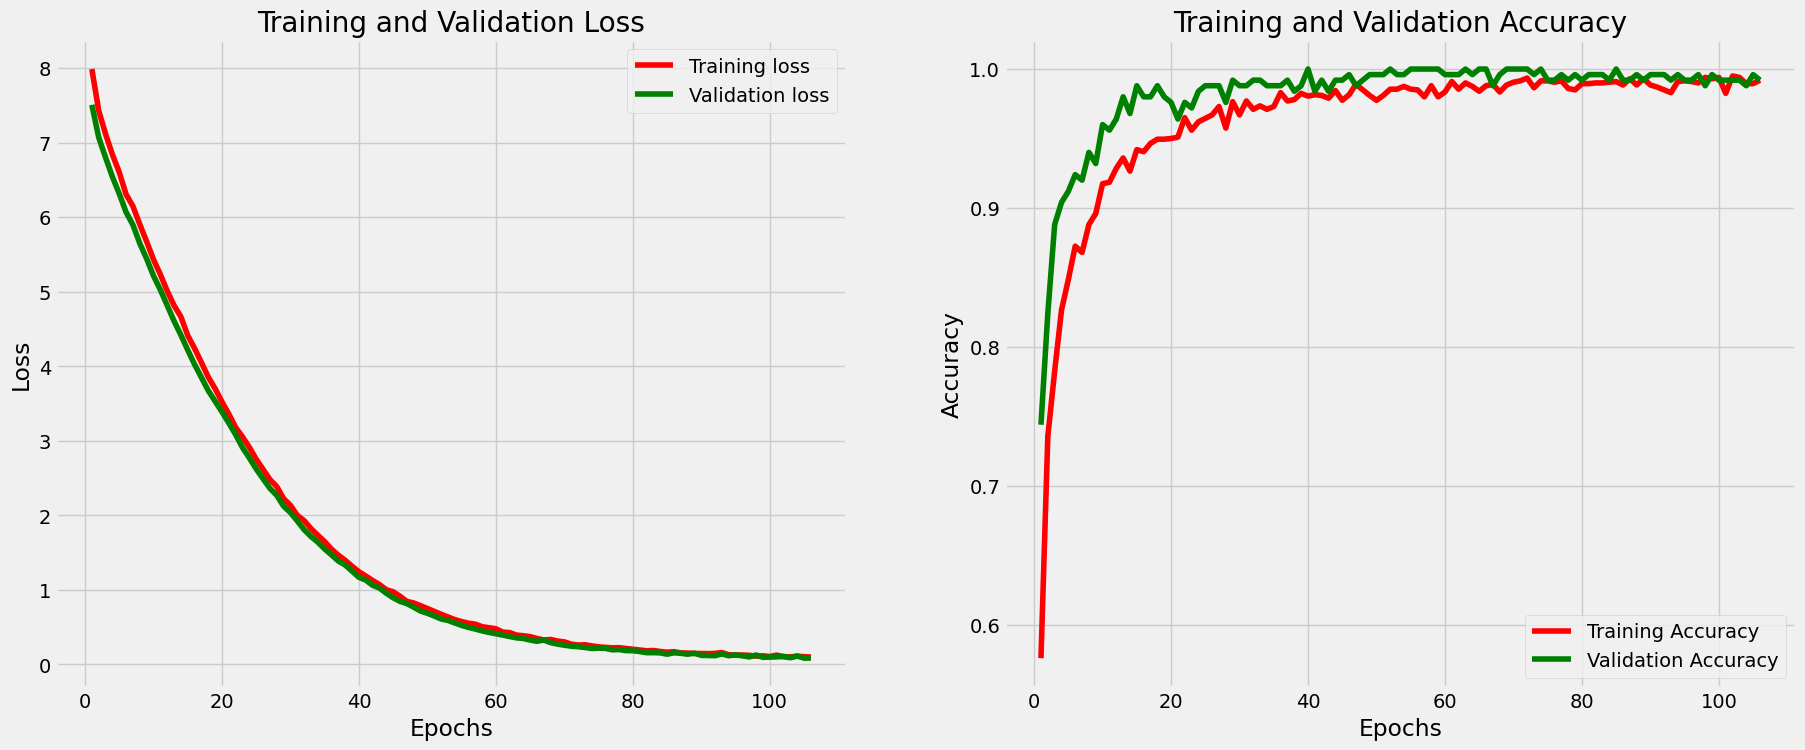

In [31]:
def model_performance(history, Epochs):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


model_performance(history, 200)

25/25 [==============================] - 6s 228ms/step


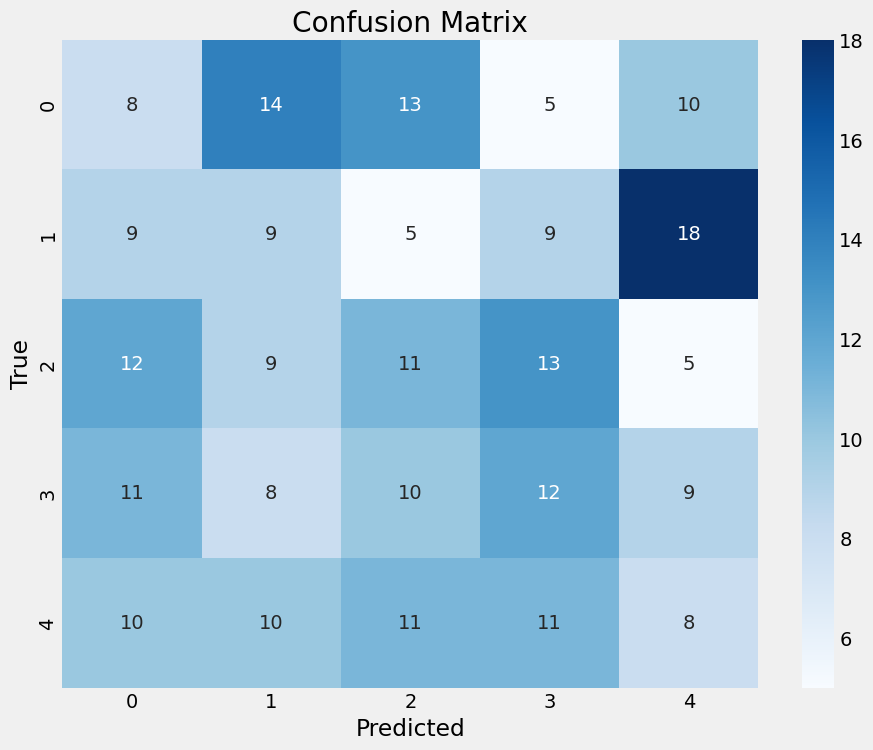

                   precision    recall  f1-score   support

  Bacterialblight       0.16      0.16      0.16        50
            Blast       0.18      0.18      0.18        50
        Brownspot       0.22      0.22      0.22        50
Healthy Rice Leaf       0.24      0.24      0.24        50
       Rice Hispa       0.16      0.16      0.16        50

         accuracy                           0.19       250
        macro avg       0.19      0.19      0.19       250
     weighted avg       0.19      0.19      0.19       250



In [32]:
# Confusion matrix
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

In [39]:
# Save the full model in H5 format
model.save('model_rice.h5')
print('Saved full model as model_rice.h5')

# Convert and save the model to TFLite format
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open('model_rice.tflite', 'wb') as tflite_file:
        tflite_file.write(tflite_model)
    print('Saved model as model_rice.tflite')
except Exception as e:
    print(f'Failed to convert to TFLite: {e}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved full model as model_rice.h5
Saved model as model_rice.tflite


In [40]:
# Download the model files
from google.colab import files

# Download Keras model
files.download('model_rice.h5')

# Download TFLite model
files.download('model_rice.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>